In [1]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Config:
    #...general params:
    workdir : str = './'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    path: str = '/home/df630/CMB/data/JetClass/TTBar_000.root'
    source:  int = 'noise'
    target: str = 'tops'
    num_jets: int = 100000
    max_num_particles = 128
    feature_continuous: List[str] = field(default_factory = lambda : ['part_pt_log', 'part_etarel', 'part_phirel'])
    feature_discrete: List[str] = field(default_factory = lambda : ['flavor', 'charge'])
    feature_context: List[str] = field(default_factory = lambda : [])

    # #...model params:
    model : str = 'transformer'
    num_attention_blocks : int = 1
    num_heads : int = 8
    dim_hidden : int = 256  
    dim_time_emb : int = 64
    dim_discrete_emb : int = 0
    time_embedding  : str = 'sinusoidal'       # 'sinusouidal' 'kolmogorov-arnold'
    attention_embedding = 'linear'           # 'linear' 'kolmogorov-arnold'
    dropout : float = 0.1
    activation : str = 'GELU'

    #...training params:
    batch_size : int = 512
    data_split_frac : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    epochs: int = 20
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 0.001

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 100
    time_eps : float = 1e-3

    def __post_init__(self):
        self.data = self.source + '_to_' + self.target
        self.dim_continuous = len(self.feature_continuous)
        self.dim_discrete = len(self.feature_discrete) 
        self.dim_context = len(self.feature_context)
        if self.multi_gpu: self.device = 'cuda:0'
        if self.dim_discrete == 0: self.dim_discrete_emb = 0




In [3]:
# from cmb.data.jetclass import JetClassDataClass
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Config()
jets = JetClassDataClass(config, standardize=False)
dynamics = ConditionalFlowMatching(config)

2024-09-09 20:29:41.315768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 20:29:41.358791: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 20:29:41.359869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 20:29:42.133557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from cmb.models.architectures.utils import (get_activation_function, 
                                            KANLinear, 
                                            SinusoidalPositionalEncoding,
                                            MultiHeadAttention)

class ParticleTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.device = config.device
        self.particle_embedding = ParticleEmbedding(config)
        self.particle_attention_blocks = []
        self.particle_attention_blocks = nn.ModuleList([ParticleAttentionBlock(
                                                        dim_input=config.dim_hidden, 
                                                        dim_output=config.dim_hidden, 
                                                        dim_hidden=config.dim_hidden, 
                                                        num_heads=config.num_heads, 
                                                        activation=get_activation_function(config.activation), 
                                                        dropout=config.dropout, 
                                                        attention_embedding='linear') 
                                                        for _ in range(config.num_attention_blocks)])
        self.projection = nn.Linear(config.dim_hidden, config.dim_continuous)
                                                
    def forward(self, t, x, k=None, context=None, mask=None):

        t = t.to(self.device) # time
        x = x.to(self.device) # continuous feature (b, n, dim_continuous) 
        k = k.to(self.device) if k is not None else None  # discrete feature (b, n, dim_discrete)          
        mask = torch.ones_like(x[...,0]).unsqueeze(-1) if mask is None else mask.unsqueeze(-1) 
        mask = mask.to(self.device)    

        h = self.particle_embedding(t=t, x=x, mask=mask)
        h_skip = h
        for block in self.particle_attention_blocks:
            h = block(h, mask, skip_connection=h_skip)
        h = self.projection(h) * mask
        return h

class ParticleEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.time_embedding == 'sinusoidal': self.time_embedding = nn.Sequential(SinusoidalPositionalEncoding(config.dim_time_emb, max_period=10000), nn.Linear(config.dim_time_emb, config.dim_time_emb))
        elif config.time_embedding == 'kolmogorov-arnold': self.time_embedding = nn.Sequential(KANLinear(1, config.dim_time_emb), nn.Linear(config.dim_time_emb, config.dim_time_emb))
        elif config.time_embedding is None: self.time_embedding = nn.Identity()
        else: raise NotImplementedError

        self.embedding = nn.Linear(config.dim_continuous + config.dim_time_emb, config.dim_hidden)

    def forward(self, t, x, k=None, mask=None):
        t_emb = self.time_embedding(t.squeeze(-1))
        t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)
        h = torch.concat([t_emb, x], dim=-1) 
        h = self.embedding(h)
        return h * mask

class ParticleAttentionBlock(nn.Module):
    def __init__(self, dim_input, dim_output, dim_hidden=128, num_heads=4, activation=nn.GELU(), dropout=0.0, attention_embedding='linear'):
        super().__init__()

        self.layernorm_0 = nn.LayerNorm(dim_input)
        self.mha_block = MultiHeadAttention(dim_input, dim_hidden, dim_hidden, num_heads, dropout, attention_embedding=attention_embedding)
        self.layernorm_1 = nn.LayerNorm(dim_hidden)
        self.layernorm_2 = nn.LayerNorm(dim_hidden)
        self.fc_block = nn.Sequential(nn.Linear(dim_hidden, dim_hidden),
                                      activation,
                                      nn.LayerNorm(dim_hidden),
                                      nn.Linear(dim_hidden, dim_output))
    def forward(self, x, mask, skip_connection=None):
        h = self.layernorm_0(x)
        h = self.mha_block(h, mask=mask)
        h = self.layernorm_1(h)
        h += x
        f = self.layernorm_2(h)
        f = self.fc_block(f) * mask
        f += h if skip_connection is None else skip_connection
        return f


class MultiHeadAttention(nn.Module):
    def __init__(self, dim_input, dim_output, dim_hidden=128, num_heads=4, dropout=0.0, attention_embedding='linear'):
        super().__init__()

        assert dim_hidden % num_heads == 0, "hidden dimension must be divisible by number of heads"
        self.dim_head= dim_hidden // num_heads
        self.num_head = num_heads
        self.dim_hidden = dim_hidden
        self.register_buffer("tril", torch.tril(torch.ones(dim_hidden, dim_hidden)))

        if attention_embedding == 'linear': 
            self.k = nn.Linear(dim_input, dim_hidden, bias=False)
            self.q = nn.Linear(dim_input, dim_hidden, bias=False)
            self.v = nn.Linear(dim_input, dim_hidden, bias=False)
        elif attention_embedding == 'kolmogorov-arnold': 
            self.k = KANLinear(dim_input, dim_hidden)
            self.q = KANLinear(dim_input, dim_hidden)
            self.v = KANLinear(dim_input, dim_hidden)
            
        self.proj = nn.Linear(dim_hidden, dim_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):

        b, n, dim = x.shape
        K, V, Q  = self.k(x), self.v(x), self.q(x)  # (B, T, E)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, n, d) -> (b, n, num_heads, head_dim)
        K = K.view(b, n, self.num_head, self.dim_head)
        V = V.view(b, n, self.num_head, self.dim_head)
        Q = Q.view(b, n, self.num_head, self.dim_head)

        # Transpose: (b, n, num_head, head_dim) -> (b, num_head, n, head_dim)
        K = K.transpose(1, 2)
        Q = Q.transpose(1, 2)
        V = V.transpose(1, 2)

        # Compute scaled dot-product attention
        # (b, num_head, n, head_dim) @ (b, num_head, head_dim, n) -> (b, num_head,n, n)
        QK = Q @ K.transpose(2, 3) * K.shape[-1] ** -0.5

        if mask is not None:
            mask = mask.expand(-1, -1, n)  # (b, n) -> (b, n, n)
            # (b, n, n) -> (b, num_head, n, n)
            mask = mask.unsqueeze(1).expand(b, self.num_head, n, n)
            # Need to set a finite number for the masking, instead of -inf,
            # otherwise softmax results in nans.
            # (b, num_head, n, n)
            QK = QK.masked_fill(mask == 0, float("-1e9"))

        # Apply the causal mask, cropped to the sequence length
        # (b, num_head, n, n)
        QK = QK.masked_fill(self.tril[:n, :n] == 0, float("-inf"))

        A = F.softmax(QK, dim=-1)  # (B, num_head, T, T)
        A = self.dropout(A)

        # attn_weights have shape (b, num_head, n, n) and V (b, num_head, n, head_dim)
        # (b, num_head, n, head_dim) -> (b, n, num_head, head_dim)
        context_vec = (A @ V).transpose(1, 2)

        # Combine heads, where dim_hidden = num_head * dim_head
        context_vec = context_vec.contiguous().view(b, n, self.dim_hidden)
        context_vec = self.proj(context_vec)

        return context_vec


In [5]:
from cmb.models.trainers import CMBTrainer

parT = ParticleTransformer(config)
generative_model = CMBTrainer(dynamics, parT, jets)

print(parT)
generative_model.train()


number of training parameters: 418371
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 83334, validation size: 16666, testing sizes: 0
ParticleTransformer(
  (particle_embedding): ParticleEmbedding(
    (time_embedding): Sequential(
      (0): SinusoidalPositionalEncoding()
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (embedding): Linear(in_features=67, out_features=256, bias=True)
  )
  (particle_attention_blocks): ModuleList(
    (0): ParticleAttentionBlock(
      (layernorm_0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha_block): MultiHeadAttention(
        (k): Linear(in_features=256, out_features=256, bias=False)
        (q): Linear(in_features=256, out_features=256, bias=False)
        (v): Linear(in_features=256, out_features=256, bias=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm_1): LayerNorm((256,), eps=1e-05, e

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

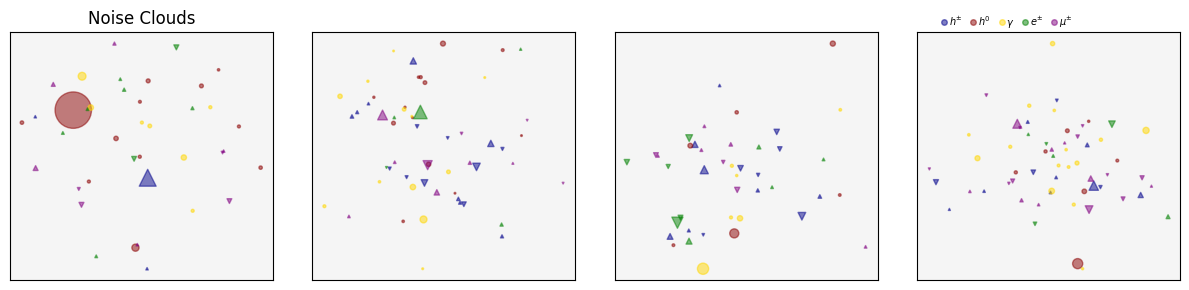

In [18]:
import matplotlib.pyplot as plt
# from cmb.data.jetclass import NoiseClouds

noise = NoiseClouds(num_clouds=1000, masks_like=jets.target)

fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
noise.display_cloud(idx=0, ax=ax[0])
noise.display_cloud(idx=1, ax=ax[1])
noise.display_cloud(idx=2, ax=ax[2])
noise.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Noise Clouds')
plt.tight_layout()
plt.show()


In [19]:

import torch
from dataclasses import dataclass
# from cmb.models.utils import EulerSolver, ContextWrapper

class CFMPipeline:
    
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=False,
                 ):

        self.config = config
        self.trained_model = trained_model
        self.model = self.trained_model.best_epoch_model if best_epoch_model else self.trained_model.last_epoch_model
        self.num_sampling_steps = config.num_timesteps
        self.sampler = config.sampler
        self.device = config.device
        self.has_context = False
        self.time_steps = torch.linspace(0.0, 1.0, config.num_timesteps, device=self.device)

    def generate_samples(self, input_source):
        self.source_continuous = input_source.continuous.to(self.device)
        self.source_discrete = input_source.discrete.to(self.device)
        self.mask = input_source.mask.to(self.device)
        self.context = input_source.context.to(self.device) if self.has_context else None
        self.trajectories = self.ODEsolver() 

    @torch.no_grad()
    def ODEsolver(self):

        print('INFO: {} with {} method and steps={}'.format(self.sampler, self.config.solver, self.config.num_timesteps))

        drift = ContextWrapper(self.model, context=self.context, mask=self.mask)

        if self.sampler == 'EulerSolver':
            node = EulerSolver(vector_field=drift, device=self.device)
        
        trajectories = node.trajectory(x=self.source_continuous, t_span=self.time_steps)
        x1 = trajectories[-1].detach().cpu()
        mask = self.mask.unsqueeze(-1).detach().cpu()
        x1 = torch.cat([x1, mask], dim=-1) * mask 

        return ParticleClouds(data=x1)
    

class ContextWrapper(torch.nn.Module):
    """ Wraps model to torchdyn compatible format.
    """
    def __init__(self, net, context=None, mask=None):
        super().__init__()
        self.nn = net
        self.context = context
        self.mask = mask
    def forward(self, t, x, k):
        if x is not None: 
            t = t.repeat(x.shape[0])
            t = self.reshape_time_like(t, x)
        else: 
            t = t.repeat(k.shape[0])
            t = self.reshape_time_like(t, k)
        return self.nn(t=t, x=x, k=k, context=self.context, mask=self.mask)

    def reshape_time_like(self, t, tensor):
        if isinstance(t, (float, int)): return t
        else: return t.reshape(-1, *([1] * (tensor.dim() - 1)))


class EulerSolver:
    def __init__(self, vector_field, device):
        self.vector_field = vector_field
        self.device = device

    def trajectory(self, t_span, x, k=None):
        time_steps = len(t_span)
        dt = (t_span[-1] - t_span[0]) / (time_steps - 1)
        trajectory = [x]

        for i in range(1, time_steps):
            t = t_span[i-1]
            x = x + dt * self.vector_field(t, x=x, k=k).to(self.device)
            trajectory.append(x)

        return torch.stack(trajectory)


In [20]:

pipeline = CFMPipeline(trained_model=generative_model, config=config)
with torch.no_grad():
    pipeline.generate_samples(noise)

INFO: EulerSolver with euler method and steps=200


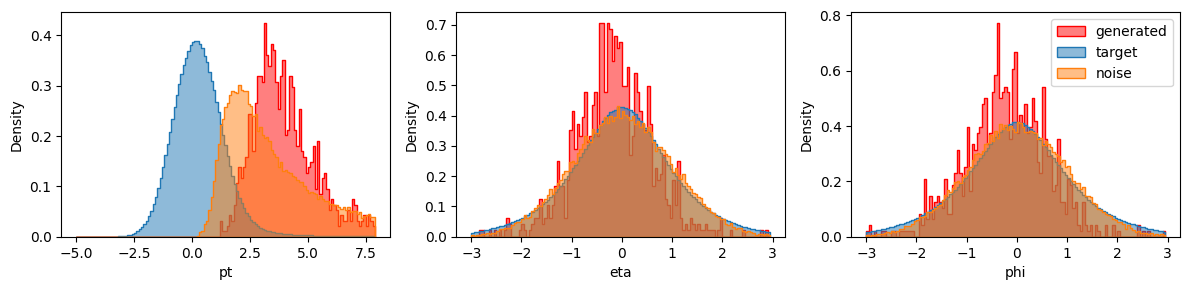

In [24]:
import seaborn as sns
import numpy as np

x1 = pipeline.trajectories

x_gen = x1.continuous.flatten(start_dim=1)
fig, ax = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(x_gen[:,0],bins=np.arange(-5, 8,0.1), ax=ax[0], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('pt',bins=np.arange(-5, 8,0.1), ax=ax[0], stat='density', alpha=0.5, label='target')
noise.histplot('pt', bins=np.arange(-5, 8,0.1), ax=ax[0], stat='density', alpha=0.5, label='noise')

sns.histplot(x_gen[:,1], bins=np.arange(-3, 3,0.05), ax=ax[1], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('eta', bins=np.arange(-3, 3,0.05),ax=ax[1], stat='density', alpha=0.5, label='target')
noise.histplot('eta', bins=np.arange(-3, 3,0.05), ax=ax[1], stat='density', alpha=0.5, label='noise')

sns.histplot(x_gen[:,2], bins=np.arange(-3, 3,0.05), ax=ax[2], color='r', stat='density', element="step", alpha=0.5, label='generated')
jets.target.histplot('phi', bins=np.arange(-3, 3,0.05), ax=ax[2], stat='density', alpha=0.5, label='target')
noise.histplot('phi', bins=np.arange(-3, 3,0.05), ax=ax[2], stat='density', alpha=0.5, label='noise')
ax[2].legend()
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import torch
import awkward as ak
import fastjet
import vector
import uproot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.lines import Line2D
from dataclasses import dataclass
from torch.distributions.categorical import Categorical

vector.register_awkward()

class JetClassDataClass:
    def __init__(self, config: dataclass, discrete_features: bool=True, standardize: bool=False):
        self.config = config

        if config.target == 'tops':
            self.target = ParticleClouds(config.path, max_num_particles=config.max_num_particles, features_discrete=discrete_features, standardize=standardize)
            
        if config.source == 'noise':
            self.source = NoiseClouds(num_clouds=len(self.target), max_num_particles=config.max_num_particles, features_discrete=discrete_features, masks_like=self.target)



class ParticleClouds:
    def __init__(self, 
                 data,
                 max_num_particles=128,
                 features_discrete=False,
                 standardize=False):

        if isinstance(data, str):
            assert  '.root' in data, 'Input should be a path to a .root file or a tensor'
            data = self.read_root_file(data)
            features = ['part_ptrel', 'part_etarel', 'part_phirel', 'part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'part_charge', 'mask']       
            data = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], maxlen=max_num_particles)) for feat in features] , axis=1))
            data = torch.permute(data, (0,2,1))
        else:
            assert isinstance(data, torch.Tensor), 'Input should be a path to a .root file or a tensor'

        idx = torch.argsort(data[...,0], dim=1, descending=True)
        data_pt_sorted = torch.gather(data, 1, idx.unsqueeze(-1).expand(-1, -1, data.size(2)))
        self.continuous = data_pt_sorted[...,:3]
        if standardize:
            self.continuous = (self.continuous - self.continuous.mean(0)) / self.continuous.std(0)
        self.mask = data_pt_sorted[...,-1].long()
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]

        if features_discrete:
            self.isChargedHadron = data_pt_sorted[...,3]
            self.isNeutralHadron = data_pt_sorted[...,4]
            self.isPhoton = data_pt_sorted[...,5]
            self.isElectron = data_pt_sorted[...,6]
            self.isMuon = data_pt_sorted[...,7]
            self.flavor = torch.argmax(data_pt_sorted[...,3:8], dim=2)
            self.charge = data_pt_sorted[...,8]
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2) 

        self.multiplicity = torch.sum(self.mask, dim=1)
        
    def __len__(self):
        return self.continuous.shape[0]
    
    def read_root_file(self, filepath):
        
        """Loads a single .root file from the JetClass dataset.
        """
        x = uproot.open(filepath)['tree'].arrays()
        x['part_pt'] = np.hypot(x['part_px'], x['part_py'])
        x['part_pt_log'] = np.log(x['part_pt'])
        x['part_ptrel'] = x['part_pt'] / x['jet_pt']
        x['part_deltaR'] = np.hypot(x['part_deta'], x['part_dphi'])

        p4 = vector.zip({'px': x['part_px'],
                         'py': x['part_py'],
                         'pz': x['part_pz'],
                         'energy': x['part_energy']})
        
        x['part_eta'] = p4.eta
        x['part_phi'] = p4.phi
        x['part_etarel'] = p4.eta - x['jet_eta'] 
        x['part_phirel'] = (p4.phi - x['jet_phi'] + np.pi) % (2 * np.pi) - np.pi
        x['mask'] = np.ones_like(x['part_energy']) 
        f = ak.concatenate([x['part_isChargedHadron'], x['part_isNeutralHadron'], x['part_isPhoton'], x['part_isElectron'], x['part_isMuon']], axis=1)
        x['flavor'] = ak.argmax(f, axis=1)
        return x
    
    def pad(self, a, maxlen, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
                return x
    
    def summary_stats(self):
        data = self.continuous[self.mask > 0]
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}

    def histogram(self, features='pt', num_bins=100, density=True, use_quantiles=False):
        mask = self.mask > 0
        x = getattr(self, features)[mask]
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.constituents.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wasserstein1D(self, feature, reference):
        mask = self.mask > 0
        x = getattr(self, feature)[mask]
        y = getattr(reference.constituents, feature)[mask]
        return scipy.stats.wasserstein_distance(x, y)

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = np.log(1000 * self.pt[idx].numpy())
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background


class NoiseClouds:
    def __init__(self, 
                num_clouds, 
                max_num_particles=128,
                masks_like=None,
                features_discrete=False):
        self.num_clouds = num_clouds
        self.max_num_particles = max_num_particles 

        continuous = torch.randn((num_clouds, max_num_particles, 3))
        idx = torch.argsort(continuous[...,0], dim=1, descending=True)
        self.continuous = torch.gather(continuous, 1, idx.unsqueeze(-1).expand(-1, -1, continuous.size(2)))
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]
        self.sample_masks(masks_like=masks_like)

        self.multiplicity = torch.sum(self.mask, dim=1)

        if features_discrete:
            flavor = np.random.choice([0,1,2,3,4], size=(num_clouds, max_num_particles))
            charge = np.random.choice([-1, 1], size=(num_clouds, max_num_particles))
            charge = np.where((flavor==1) | (flavor==2), 0, charge)
            self.flavor = torch.tensor(flavor).long()
            self.charge = torch.tensor(charge).long()
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

            self.isChargedHadron = torch.zeros((num_clouds, max_num_particles))
            self.isNeutralHadron = torch.zeros((num_clouds, max_num_particles))
            self.isPhoton = torch.zeros((num_clouds, max_num_particles))
            self.isElectron = torch.zeros((num_clouds, max_num_particles))
            self.isMuon = torch.zeros((num_clouds, max_num_particles))

            self.isChargedHadron[self.flavor==0] = 1
            self.isNeutralHadron[self.flavor==1] = 1
            self.isPhoton[self.flavor==2] = 1
            self.isElectron[self.flavor==3] = 1
            self.isMuon[self.flavor==4] = 1

    def __len__(self):
        return self.num_clouds 
    
    def sample_masks(self, masks_like=None):
        if masks_like is None:   
            self.mask = torch.ones_like(self.pt) 
        else:
            masks_like = masks_like.multiplicity
            histogram = torch.tensor(np.histogram(masks_like, bins=np.arange(0, torch.max(masks_like).item(), 1))[0]).long()
            probs = histogram / histogram.sum()
            cat = Categorical(probs)
            N = cat.sample((len(self),))
            masks = torch.zeros((self.num_clouds, self.max_num_particles))
            for i, n in enumerate(N):
                masks[i, :n] = 1
            self.mask = masks.long()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def summary_stats(self):
        data = self.continuous
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = np.log(1000 * self.pt[idx].numpy())
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background



In [14]:
jets = JetClassDataClass(config, discrete_features=True, standardize=True) 

/tmp/ipykernel_151827/2691141639.py:153: RuntimeWarning: invalid value encountered in log
  pt = np.log(1000 * self.pt[idx].numpy())
/tmp/ipykernel_151827/2691141639.py:284: RuntimeWarning: invalid value encountered in log
  pt = np.log(1000 * self.pt[idx].numpy())


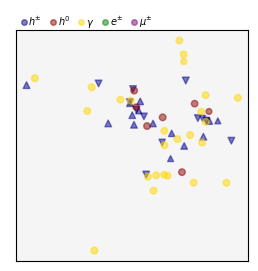

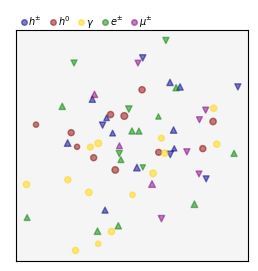

In [15]:
jets.target.display_cloud(idx=0)
jets.source.display_cloud(idx=0)

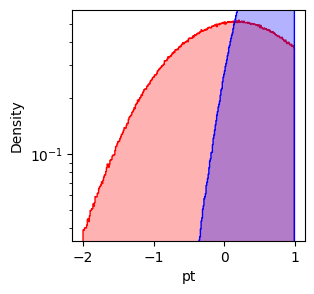

In [17]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.target.histplot('pt', bins=np.arange(-2, 1,0.01), color='r', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.source.histplot('pt', bins=np.arange(-2, 1,0.01), color='b', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


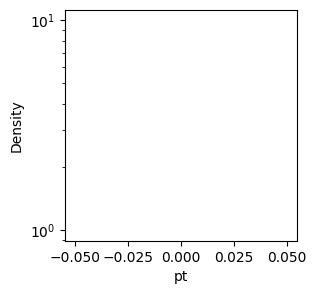

In [8]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.source.histplot('pt', bins=np.arange(0, 1,0.01), color='b', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.target.histplot('pt', bins=np.arange(0, 1,0.01), color='r', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

<Axes: ylabel='Count'>

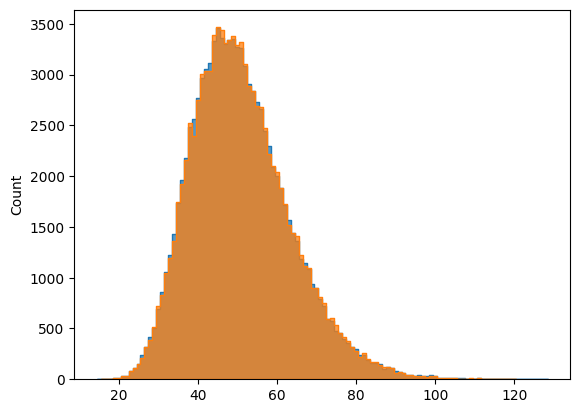

In [7]:
sns.histplot(jets.target.multiplicity, element='step', discrete=True)
sns.histplot(jets.source.multiplicity, element='step', discrete=True)